Sources :

https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93

### Simulation function

In [3]:
def simulation(S0, vol, r, n_simulations, range_K=(0.8, 1.2), range_T=(0.5, 1.5)):
    
    K = np.random.uniform(range_K[0], range_K[1], size=n_simulations)
    T = np.random.uniform(range_T[0], range_T[1], size=n_simulations)
    
    S_final = S0*np.exp((r - 0.5*(vol**2))*T + vol*np.sqrt(T)*np.random.normal(size=n_simulations))
    Payoff = np.maximum(0, S_final - K)
    
    dataframe = pd.DataFrame({'Strike': K, 'Maturity': T, 'Payoff' : Payoff})
    
    return dataframe

In [4]:
data = simulation(1, 0.1, 0.03, 10000)
data

Strike  Maturity    Payoff
0     0.928536  1.239425  0.195351
1     0.897110  0.748402  0.266666
2     0.993189  0.734445  0.054856
3     1.171777  1.315069  0.000000
4     0.909435  0.639344  0.086289
...        ...       ...       ...
9995  1.117531  0.774607  0.000000
9996  1.153653  1.454283  0.000000
9997  1.049161  1.470567  0.209108
9998  0.970591  0.838626  0.043501
9999  0.956816  1.389740  0.000000

[10000 rows x 3 columns]

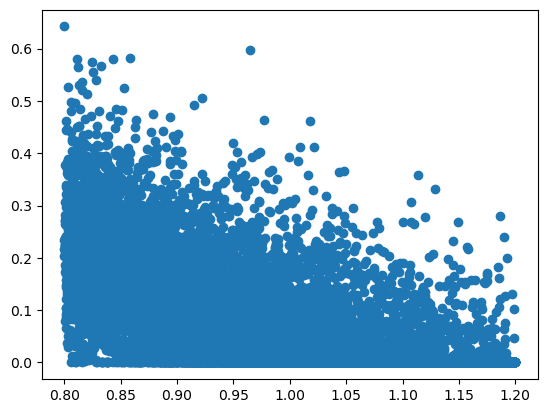

In [5]:
plt.scatter(data.Strike, data.Payoff)

### Data 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

In [7]:
class BlackScholesDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [50]:
data = simulation(100, 0.1, 0.03, 1000000, range_K = (90, 110))

In [51]:
y = data.Payoff
X = data.drop(columns='Payoff')

In [52]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)

In [53]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [54]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

In [55]:
train_dataset = BlackScholesDataset(torch.from_numpy(X_train).type(torch.float32), torch.from_numpy(y_train).type(torch.float32))
val_dataset = BlackScholesDataset(torch.from_numpy(X_val).type(torch.float32), torch.from_numpy(y_val).type(torch.float32))
test_dataset = BlackScholesDataset(torch.from_numpy(X_test).type(torch.float32), torch.from_numpy(y_test).type(torch.float32))


In [56]:
BATCH_SIZE = 2 ** 13
BATCH_SIZE

8192

In [57]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

## Neural Network

In [8]:
try:
    device = torch.device("mps")
    print('Using MPS')
except RuntimeError:
    try:
        device = torch.device("cuda")
        print("Using CUDA")
    except RuntimeError:
        device = torch.device("cpu")
        print('Using CPU')

Using MPS


### We define the NN

In [59]:
EPOCHS = 100
LEARNING_RATE = 1e-4
NUM_FEATURES = 2 #len(X.columns)

In [60]:
class BlackScholesRegression(nn.Module):
    def __init__(self, num_features):
        super(BlackScholesRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 32)
        self.layer_2 = nn.Linear(32, 64)
        self.layer_3 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 1)
        
        self.activation = nn.LeakyReLU()
        self.activation_out = nn.Identity()
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, inputs):
        x = self.activation(self.layer_1(inputs))
        x = self.activation(self.layer_2(x))
        x = self.dropout(x)
        x = self.activation(self.layer_3(x))
        x = self.dropout(x)
        x = self.activation_out(self.layer_out(x))
        return x

    def predict(self, test_inputs):
        x = self.activation(self.layer_1(test_inputs))
        x = self.activation(self.layer_2(x))
        x = self.dropout(x)
        x = self.activation(self.layer_3(x))
        x = self.dropout(x)
        x = self.activation_out(self.layer_out(x))
        return x

In [61]:
model = BlackScholesRegression(NUM_FEATURES)
model.to(device)

BlackScholesRegression(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (activation_out): Identity()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [62]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Training the model

In [63]:
loss_stats = {
    'train': [],
    "val": []
}

In [64]:
print("Begin training.")

for e in range(1, EPOCHS+1):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.
Epoch 001: | Train Loss: 108.91123 | Val Loss: 107.25160
Epoch 002: | Train Loss: 105.65769 | Val Loss: 102.29950
Epoch 003: | Train Loss: 98.71134 | Val Loss: 93.39148
Epoch 004: | Train Loss: 88.51655 | Val Loss: 82.34451
Epoch 005: | Train Loss: 78.77539 | Val Loss: 74.25867
Epoch 006: | Train Loss: 73.36376 | Val Loss: 70.61217
Epoch 007: | Train Loss: 70.87165 | Val Loss: 68.55350
Epoch 008: | Train Loss: 69.02174 | Val Loss: 66.75474
Epoch 009: | Train Loss: 67.24200 | Val Loss: 64.90724
Epoch 010: | Train Loss: 65.41446 | Val Loss: 62.97974
Epoch 011: | Train Loss: 63.46708 | Val Loss: 61.01086
Epoch 012: | Train Loss: 61.62641 | Val Loss: 59.23912
Epoch 013: | Train Loss: 60.04833 | Val Loss: 57.80618
Epoch 014: | Train Loss: 58.95180 | Val Loss: 56.83933
Epoch 015: | Train Loss: 58.28429 | Val Loss: 56.38796
Epoch 016: | Train Loss: 58.08729 | Val Loss: 56.20160
Epoch 017: | Train Loss: 57.90916 | Val Loss: 56.11632
Epoch 018: | Train Loss: 57.84442 | Val Loss:

In [65]:
y_test_pred = model.predict(torch.from_numpy(X_test).float().to(device)).detach().cpu().numpy()

In [66]:
X_test.shape

(200000, 2)

In [67]:
y_test_pred

array([[ 8.747685 ],
       [12.139461 ],
       [ 2.4805155],
       ...,
       [11.190856 ],
       [ 2.1380332],
       [12.629104 ]], dtype=float32)

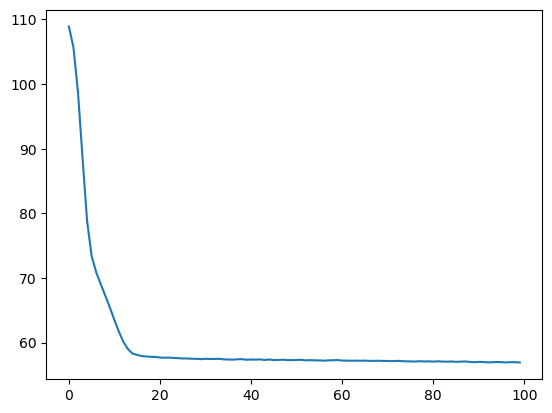

In [68]:
plt.plot(loss_stats['train'])

## Plotting the surfaces

In [42]:
import plotly.graph_objects as go

In [70]:
X_test_original = scaler.inverse_transform(X_test)
X_test_original

array([[ 96.15461954,   1.16222316],
       [ 91.6234343 ,   1.10179578],
       [107.61009892,   1.06627768],
       ...,
       [ 92.38887662,   0.99949609],
       [107.57457565,   0.96473195],
       [ 92.54810967,   1.4966611 ]])

In [71]:
y_test_pred.flatten()

array([ 8.747685 , 12.139461 ,  2.4805155, ..., 11.190856 ,  2.1380332,
       12.629104 ], dtype=float32)

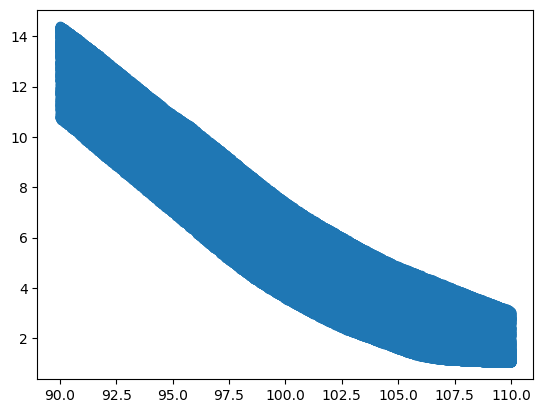

In [72]:
plt.scatter(X_test_original[:, 0], y_test_pred)

#### True Black-Scholes Price

In [39]:
def black_scholes_price(K, T, S, vol, r=0):
    d_plus = (np.log(S/K) + r*T) / (vol*np.sqrt(T)) + 1/2 * vol * np.sqrt(T)
    d_minus = (np.log(S/K) + r*T) / (vol*np.sqrt(T)) - 1/2 * vol * np.sqrt(T)
    
    return S * norm.cdf(d_plus) - K * np.exp(-r*T) * norm.cdf(d_minus)

In [74]:
range_K = (90, 110)
range_T = (.5, 1.5)

S0 = 100
vol = 0.1
r = 0.03

K_values = np.linspace(range_K[0], range_K[1], 100)
T_values = np.linspace(range_T[0], range_T[1], 100)

bs_call_prices = []
nn_call_prices = []

for k in K_values:
    k_prices_bs = []
    k_prices_nn = []
    for t in T_values:
        k_prices_bs.append(black_scholes_price(k, t, S0, vol, r))
        #k_prices_nn.append(model.predict())
    bs_call_prices.append(k_prices_bs)

In [75]:
fig = go.Figure(data=[go.Surface(z=bs_call_prices, x=K_values, y=T_values)])

fig.update_layout(title='Surface of true BS Call Prices', autosize=False,
                  width=700, height=700,
                  xaxis_title="K",)

fig.show()

#### NN price

In [82]:
range_K = (90, 110)
range_T = (.5, 1.5)

S0 = 100
vol = 0.1

K_values = np.linspace(range_K[0], range_K[1], 100)
T_values = np.linspace(range_T[0], range_T[1], 100)

test_array = np.array([K_values, T_values[0]*np.ones(len(K_values))])
test_array = scaler.transform(test_array.T)
y_test_pred = model.predict(torch.from_numpy(test_array).float().to(device)).detach().cpu().numpy()
grid_pred = y_test_pred


for t in T_values[1:]:
    test_array = np.array([K_values, t*np.ones(len(K_values))])
    test_array = scaler.transform(test_array.T)
    y_test_pred = model.predict(torch.from_numpy(test_array).float().to(device)).detach().cpu().numpy()
    grid_pred = np.column_stack((grid_pred, y_test_pred))

In [83]:
fig = go.Figure(data=[go.Surface(z=grid_pred, x=K_values, y=T_values)])
#fig.add_trace(go.Surface(z=bs_call_prices, x=K_values, y=T_values))

fig.update_layout(title='Surface of NN Call Prices', autosize=False,
                  width=700, height=700,
                  xaxis_title="K",)

fig.show()

In [86]:
print("RMSE :")
np.sqrt(np.mean((grid_pred - bs_call_prices) ** 2))

RMSE :


0.1346546038751534

## Predictions using the residuals

Au lieu de prédire la valeur du prix Black-Scholes, on va essayer de prédire la valeur des résidus, entre la valeur intrinsèque du call : $e^{-rT} (S_t - K)_+$, et le payoff pour chaque simulation.

On va ensuite superposer le prix du résidu et de la valeur intrinsèque pour avoir le prix final.

In [54]:
def get_residuals(S0, vol, r, n_simulations, range_K=(0.8, 1.25), range_T=(0.5, 1.5)):
    K = np.random.uniform(range_K[0], range_K[1], size=n_simulations)
    T = np.random.uniform(range_T[0], range_T[1], size=n_simulations)
    
    S_final = S0*np.exp((r - 0.5*(vol**2))*T + vol*np.sqrt(T)*np.random.normal(size=n_simulations))
    
    payoff = np.maximum(0, S_final - K) * np.exp(-r*T)
    
    residual = payoff - np.maximum(0, S0 - K)# * np.exp(-r*T)) 
    
    dataframe = pd.DataFrame({'Strike': K, 'Maturity': T, 'residual' : residual})
    
    return dataframe
    

#### Data

In [55]:
r = 0.03
vol = 0.2
S0 = 100
range_K = (80, 120)
range_T = (0.5, 1.5)

In [56]:
data = get_residuals(S0, vol, r, 1000000, range_K = range_K, range_T = range_T)

In [57]:
data

Strike  Maturity   residual
0        90.953550  0.942785  -8.352308
1       105.008243  0.925178  17.418646
2        86.705569  0.536087  -6.620283
3        81.780458  1.333855   4.086010
4       115.074090  1.111321   0.000000
...            ...       ...        ...
999995   86.746077  0.841942  -7.475765
999996  118.561201  1.270523   0.000000
999997  112.071982  1.420546   0.000000
999998   85.329263  1.290614  -9.418044
999999  113.580464  1.207336   0.000000

[1000000 rows x 3 columns]

In [58]:
y = data.residual
X = data.drop(columns='residual')

<AxesSubplot: >

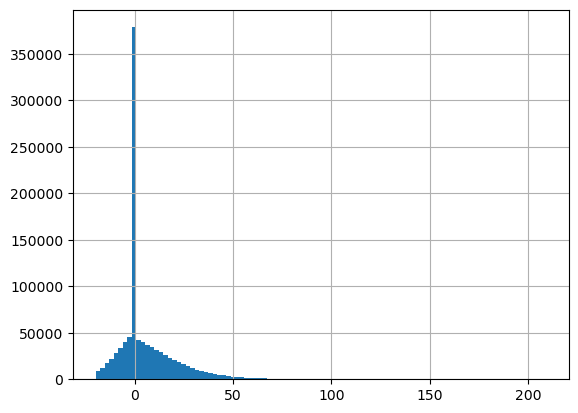

In [59]:
y.hist(bins=100)

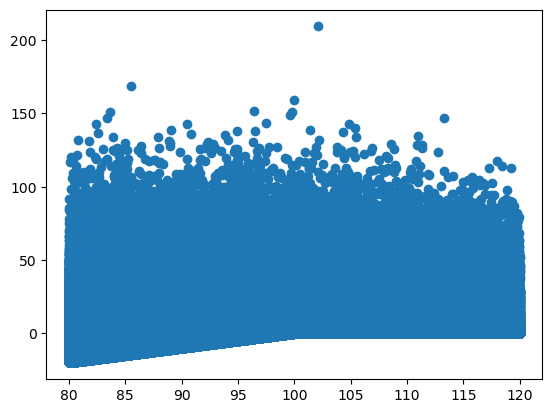

In [60]:
plt.scatter(X.Strike, y)

In [61]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)

In [62]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [63]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

In [64]:
train_dataset = BlackScholesDataset(torch.from_numpy(X_train).type(torch.float32), torch.from_numpy(y_train).type(torch.float32))
val_dataset = BlackScholesDataset(torch.from_numpy(X_val).type(torch.float32), torch.from_numpy(y_val).type(torch.float32))
test_dataset = BlackScholesDataset(torch.from_numpy(X_test).type(torch.float32), torch.from_numpy(y_test).type(torch.float32))


In [65]:
BATCH_SIZE = 8192

In [66]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

### Model

In [67]:
class ResidualRegression(nn.Module):
    def __init__(self, num_features):
        super(ResidualRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 32)
        self.layer_2 = nn.Linear(32, 256)
        self.layer_3 = nn.Linear(256, 512)
        self.layer_4 = nn.Linear(512, 512)
        self.layer_5 = nn.Linear(512, 256)
        self.layer_6 = nn.Linear(256, 64)
        self.layer_out = nn.Linear(64, 1)
        
        self.activation = nn.LeakyReLU()
        self.out_activation = nn.Softplus()
        self.dropout = nn.Dropout()
        
    def forward(self, inputs):
        x = self.activation(self.layer_1(inputs))
        x = self.activation(self.layer_2(x))
        x = self.activation(self.layer_3(x))
        x = self.activation(self.layer_4(x))
        x = self.activation(self.layer_5(x))
        x = self.activation(self.layer_6(x))
        x = self.out_activation(self.layer_out(x))
        
        return x

    def predict(self, test_inputs):
        x = self.activation(self.layer_1(test_inputs))
        x = self.activation(self.layer_2(x))
        x = self.activation(self.layer_3(x))
        x = self.activation(self.layer_4(x))
        x = self.activation(self.layer_5(x))
        x = self.activation(self.layer_6(x))
        x = self.out_activation(self.layer_out(x))
        
        return x

### Training

In [68]:
device = torch.device("mps")

In [115]:
EPOCHS = 100
LEARNING_RATE = 1e-4
NUM_FEATURES = 2 #len(X.columns)

In [116]:
res_model = ResidualRegression(NUM_FEATURES)
res_model.to(device)

ResidualRegression(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=512, bias=True)
  (layer_4): Linear(in_features=512, out_features=512, bias=True)
  (layer_5): Linear(in_features=512, out_features=256, bias=True)
  (layer_6): Linear(in_features=256, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (out_activation): Softplus(beta=1, threshold=20)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [117]:
criterion = nn.MSELoss()
optimizer = optim.Adam(res_model.parameters(), lr=LEARNING_RATE)

### Training the model

In [118]:
loss_stats = {
    'train': [],
    "val": []
}

In [119]:
print("Begin training.")
time_start = time()

for e in range(1, EPOCHS+1):
    
    # TRAINING
    train_epoch_loss = 0
    res_model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        optimizer.zero_grad(set_to_none=True)
        
        y_train_pred = res_model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        res_model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = res_model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
    

total_train_time = time() - time_start


Begin training.
Epoch 001: | Train Loss: 225.95383 | Val Loss: 209.90058
Epoch 002: | Train Loss: 210.91801 | Val Loss: 208.81359
Epoch 003: | Train Loss: 210.09873 | Val Loss: 208.00676
Epoch 004: | Train Loss: 209.04485 | Val Loss: 206.62923
Epoch 005: | Train Loss: 207.47622 | Val Loss: 205.81295
Epoch 006: | Train Loss: 207.17345 | Val Loss: 205.75283
Epoch 007: | Train Loss: 207.15712 | Val Loss: 205.87805
Epoch 008: | Train Loss: 207.11304 | Val Loss: 205.76837
Epoch 009: | Train Loss: 207.10047 | Val Loss: 205.70035
Epoch 010: | Train Loss: 207.10229 | Val Loss: 205.69643
Epoch 011: | Train Loss: 207.09808 | Val Loss: 205.85009
Epoch 012: | Train Loss: 207.10391 | Val Loss: 205.68467
Epoch 013: | Train Loss: 207.08686 | Val Loss: 205.66388
Epoch 014: | Train Loss: 207.08933 | Val Loss: 205.66700
Epoch 015: | Train Loss: 207.07074 | Val Loss: 205.66118
Epoch 016: | Train Loss: 207.06259 | Val Loss: 205.67207
Epoch 017: | Train Loss: 207.06113 | Val Loss: 205.65236
Epoch 018: | Tr

In [120]:
print("EPOCHS :", EPOCHS)
print("Batch Size :", BATCH_SIZE)
print("Learning Rate :", LEARNING_RATE)
print("Total train time (seconds): ", total_train_time)

EPOCHS : 100
Batch Size : 8192
Learning Rate : 0.0001
Total train time (seconds):  715.0427677631378


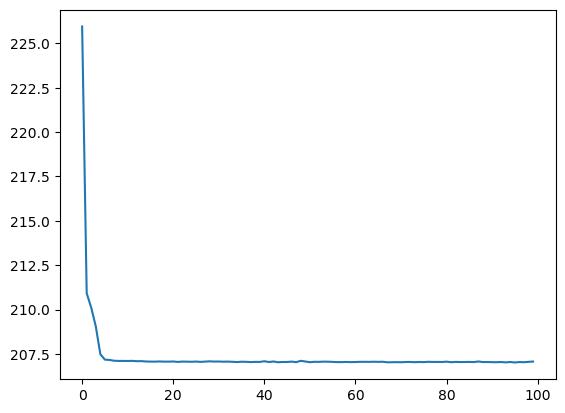

In [121]:
plt.plot(loss_stats['train'])

In [122]:
test_data = torch.from_numpy(X_test).type(torch.float32)
test_data = test_data.to(device)

In [123]:
device

device(type='mps')

In [124]:
y_test_pred = res_model.predict(test_data).detach().cpu().numpy()

In [125]:
X_test.shape

(200000, 2)

In [126]:
test_range_K = (80, 120)
test_range_T = (0.5, 1.5)

K_values = np.linspace(test_range_K[0], test_range_K[1], 200)
T_values = np.linspace(test_range_T[0], test_range_T[1], 200)

In [127]:
test_array = np.array([K_values, T_values[0]*np.ones(len(K_values))])
test_array = scaler.transform(test_array.T)
test_data = torch.from_numpy(test_array).float()
test_data = test_data.to(device)
y_test_pred = res_model.predict(test_data).detach().cpu().numpy()
prix_intrinseque = np.maximum(S0 - K_values, 0)
pred_price = y_test_pred.ravel() + prix_intrinseque
grid_pred = pred_price

for t in T_values[1:]:
    test_array = np.array([K_values, t*np.ones(len(K_values))])
    test_array = scaler.transform(test_array.T)
    test_data = torch.from_numpy(test_array).float()
    test_data = test_data.to(device)
    y_test_pred = res_model.predict(test_data).detach().cpu().numpy()
    prix_intrinseque = np.maximum(S0 - K_values, 0)
    pred_price = y_test_pred.ravel() + prix_intrinseque
    grid_pred = np.column_stack((grid_pred, pred_price))

In [128]:
bs_call_prices = []
nn_call_prices = []

for k in K_values:
    k_prices_bs = []
    k_prices_nn = []
    for t in T_values:
        k_prices_bs.append(black_scholes_price(k, t, S0, vol, r=r))
    bs_call_prices.append(k_prices_bs)

In [129]:
fig = go.Figure(data=[go.Surface(z=grid_pred, x=T_values, y=K_values)])
fig.add_trace(go.Surface(z=bs_call_prices, x=T_values, y=K_values))

fig.update_layout(title='Surface of NN Call Prices', autosize=False,
                  width=700, height=700,
                  xaxis_title="K",)

fig.show()

In [130]:
print("MAE :", np.sqrt(np.mean(np.abs(grid_pred - bs_call_prices))))

MAE : 0.3987634332932684
